In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import datetime as dt
import math

#This library also requires installing fuzzywuzzy[speedup]
from fuzzywuzzy import process 

Other potential data sources:

Somewhat irregularly collected data from Georgia universities
https://docs.google.com/document/d/1tCijdezYBswB6fjFZcLPxalbRBolAR9DDOLjBjc-oaM/edit
        
SUNY maintains one dashboard for all 64 campuses.  maybe we can scrape it?
https://www.suny.edu/covid19-tracker/

Before running this, do a git pull on `../../college-covid19-dataset` (the big10 repo)

__The directory structure should have this repository and the big10 repository both under a common parent.__

In [26]:
# nyt_datapath = '../UniversityCases/'
# big10_datapath = '../../college-covid19-dataset/data'
# In platform independent way
cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
par = os.path.abspath(par)
parpar = os.path.join(par, os.pardir)
parpar = os.path.abspath(parpar)
nyt_datapath = os.path.join(par, 'UniversityCases', '')
big10_datapath = os.path.join(parpar, 'college-covid19-dataset', 'data', '')

### Import and Clean Data

New York Times - All Schools

In [28]:
# I also had to change this part for myself (I couldn't get the re.search() to work)
# Feel free to change it back if it doesn't work for you now, the parts I changed are just commented

fnames = sorted(glob.glob(nyt_datapath+'*.csv'))
frames = []
for f in fnames:
    #m = re.search(r'[^0-9]*([0-9][0-9_]+)[^0-9]*', f)
    df = pd.read_csv(f)
    
    #df['Date'] = pd.to_datetime(m.group(1), format='%m_%d_%y')
    df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%Y')
    
    df.drop(['Unnamed: 0'], axis = 1, inplace=True)
    df['Cases'] = df['Cases'].apply(lambda x: x.replace(',', '')).astype('int')
    frames.append(df)

In [29]:
nyt_df = pd.concat(frames)

Big 10 - All dates

Data source: https://91-divoc.com/pages/covid-19-at-big-ten-conference-schools/

Note that this reports ALL cases among students, faculty, and staff (added together)

In [30]:
big10_df = pd.read_csv(os.path.join(big10_datapath, 'daily.csv'))
old_cols = big10_df.columns.values.copy()
old_cols[0] = 'School'
big10_df.columns = old_cols
big10_df['Date'] = pd.to_datetime(big10_df['Date'],format='%Y-%m-%d')

MTurk Data for one day - 11/20/2020

In [31]:
turk_df = pd.read_csv('../MTurk_Data/turk11_19_2020.csv')
turk_df['Date'] = pd.to_datetime('2020-11-19',format='%Y-%m-%d')
Cases = turk_df['CumulativeCases'].copy()
Cases[turk_df['CumulativeCases'] == 'No agreed upon value'] = np.nan
turk_df['CumulativeCases'] = Cases.astype('float')
turk_df.index = pd.MultiIndex.from_frame(turk_df[['SchoolName', 'Date']])
turk_df.drop(['SchoolName', 'Unnamed: 0', 'Date'], axis = 1, inplace = True)

The next process drops all repeated data -- only keeps values that are different from the day before

In [32]:
# Found a faster way to do it by dropping duplicates
# It should work because cumulative cases are only ever increasing 

# NOTE: for both I'm only dropping based on case numbers 
#       (not tests or anything else)

nyt_df = nyt_df.drop_duplicates(subset = ['School','Cases'])
big10_df = big10_df.drop_duplicates(subset = ['School', 'Confirmed'])

# To do that I undid the Multi Indexes you had before so put them back:

nyt_df.index = pd.MultiIndex.from_frame(nyt_df[['School', 'Date']])
nyt_df.drop(['School', 'Date'], axis = 1, inplace = True)

big10_df.index = pd.MultiIndex.from_frame(big10_df[['School', 'Date']])
big10_df.drop(['School', 'Date'], axis = 1, inplace = True)


### Inspect Data

In [33]:
turk_df.shape

(171, 7)

In [34]:
big10_df.shape

(825, 2)

In [35]:
nyt_df.shape

(8000, 6)

In [36]:
turk_df.head()

,,LastUpdate,LastUpdateAgreed,CumulativeCases,CumulativeCasesAgreed,TotalTests,TotalTestsAgreed,TotalResponses
SchoolName,Date,,,,,,,
American University,2020-11-19,2020-11-16 00:00:00,5.0,35.0,5.0,No agreed upon value,NaN,5.0
Auburn University,2020-11-19,2020-11-15 00:00:00,4.0,1467.0,4.0,No agreed upon value,NaN,5.0
Augustana College,2020-11-19,NaN,NaN,NaN,NaN,No agreed upon value,NaN,3.0
Ball State University,2020-11-19,NaN,NaN,1283.0,3.0,2767,2.0,5.0
Bard College,2020-11-19,2020-11-13 00:00:00,5.0,1.0,4.0,6194,5.0,5.0


In [37]:
big10_df.head()

Tests  Confirmed
School       Date                        
Michigan     2020-03-14   41.0          7
             2020-03-15  409.0         41
Northwestern 2020-03-19    NaN          7
Michigan     2020-03-22  662.0         81
Northwestern 2020-03-27    NaN          8

In [38]:
nyt_df.head()

,,Cases,County_Active_Cases,County_Total_Cases,City,County,State
School,Date,,,,,,
Alabama A&M University,2020-09-08,8,6574.0,6631.0,Huntsville,Madison,Alabama
Athens State University,2020-09-08,2,1697.0,1715.0,Athens,Limestone,Alabama
Auburn University*,2020-09-08,1074,3480.0,3529.0,Auburn,Lee,Alabama
Auburn University at Montgomery,2020-09-08,2,7800.0,7963.0,Montgomery,Montgomery,Alabama
Jacksonville State University,2020-09-08,219,2571.0,2602.0,Jacksonville,Calhoun,Alabama


big10 is reporting (students + employees), on campus.   NYT is reporting students, on and off campus.

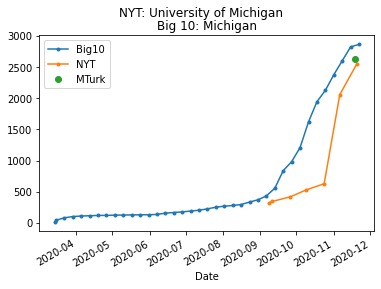

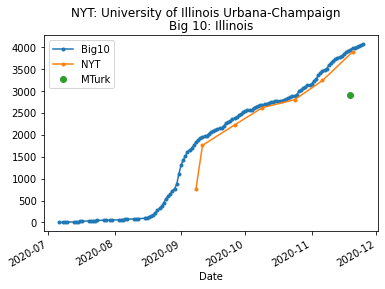

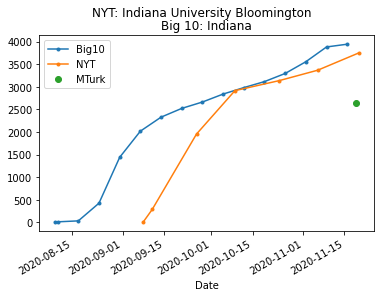

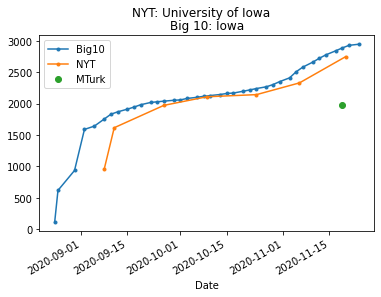

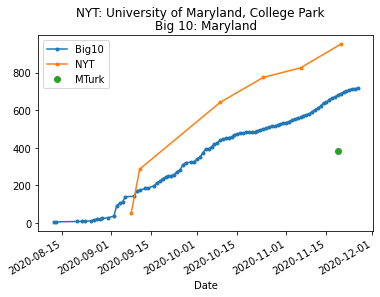

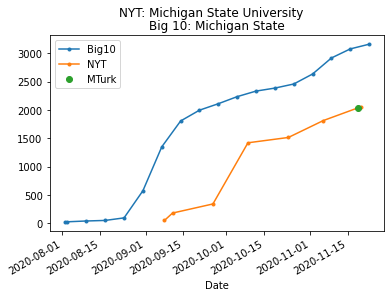

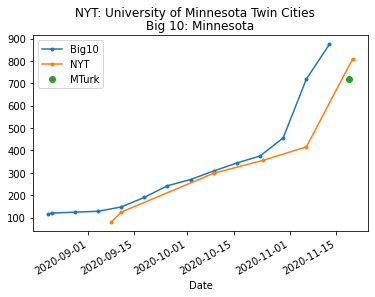

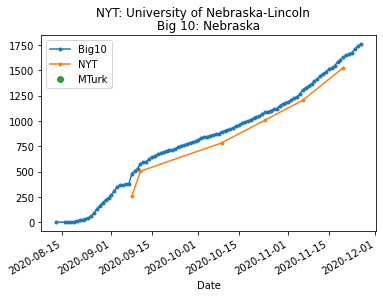

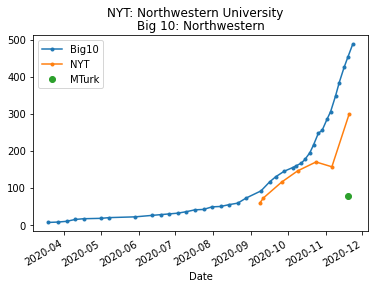

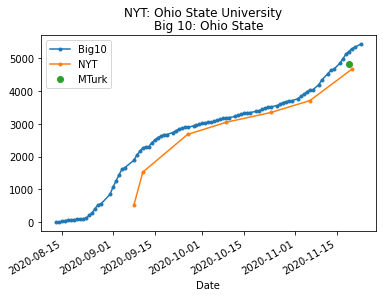

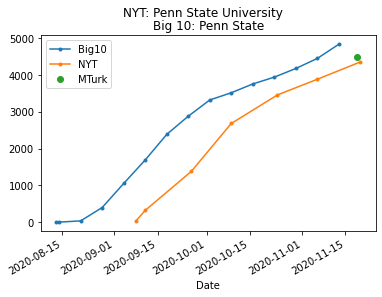

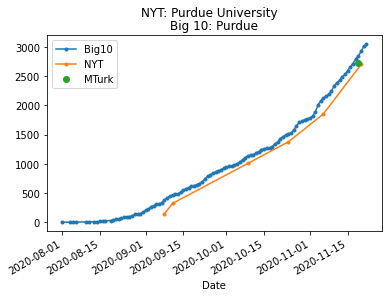

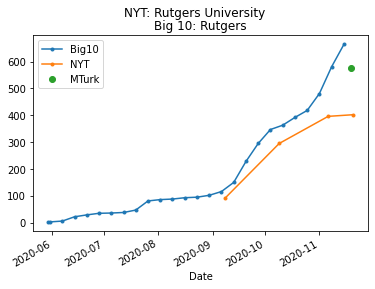

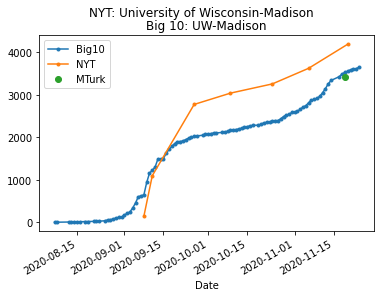

In [39]:
name_translator = [('Michigan', 'University of Michigan', 'University of Michigan'), 
                           ('Illinois', 'University of Illinois Urbana-Champaign', 'University of Illinois Urbana Champaign '),
                           ('Indiana', 'Indiana University Bloomington', 'Indiana University'),
                           ('Iowa', 'University of Iowa', 'University of Iowa'),
                           ('Maryland', 'University of Maryland, College Park', 'University of Maryland'),
                           ('Michigan State', 'Michigan State University', 'Michigan State University'),
                           ('Minnesota', 'University of Minnesota Twin Cities', 'University of Minnesota'),
                           ('Nebraska', 'University of Nebraska-Lincoln', 'University of Nebraska-Lincoln'),
                           ('Northwestern', 'Northwestern University', 'Northwestern University'),
                           ('Ohio State', 'Ohio State University', 'Ohio State University'),
                           ('Penn State', 'Penn State University', 'Penn State University'),
                           ('Purdue', 'Purdue University', 'Purdue University'),
                           ('Rutgers', 'Rutgers University', 'Rutgers University'),
                           ('UW-Madison', 'University of Wisconsin-Madison', 'University of Wisconsin Madison')]

for b10_name, nyt_name, turk_name in name_translator:
    fig, ax = plt.subplots(1)
    big10_df.loc[b10_name]['Confirmed'].plot(style = '.-', ax = ax, label = 'Big10')
    nyt_df.loc[nyt_name]['Cases'].plot(style = '.-', ax = ax, label = 'NYT')
    turk_df.loc[turk_name]['CumulativeCases'].plot(style = 'o', ax = ax, label = 'MTurk')
    plt.suptitle('NYT: {}'.format(nyt_name))
    plt.title('Big 10: {}'.format(b10_name))
    plt.legend(loc = 'best')

### Closer look at the differences between datasets

In [40]:
# first deal with the school name problem by using fuzzywuzzy
# This process is costly but saves me alot of work
# I did have to do a few of them manually 

manual = {'Butler':'Butler University', 'Cal Poly ': 'California Polytechnic State University, San Luis Obispo',
        "College of Saint Benedict/ Saint John's University": "","College of William and Mary":"William & Mary",
        "Columbia":"Columbia University", 'Georgia Tech': 'Georgia Institute of Technology',
        'Indiana University':'Indiana University Bloomington', 'State University of New York': '',
        'University of Maryland':'University of Maryland, College Park', 'University of Minnesota':'University of Minnesota Twin Cities',
        'University of Tennessee':'University of Tennessee, Knoxville', 'University of West Virginia ':'West Virginia University',
        'Williams University':'Williams College'
        }

name_dict = {}
for turk in turk_df.index.levels[0]:
    try:
        nyt_test = nyt_df.loc[turk]
        name_dict[turk] = turk
    except: 
        if turk in manual:
            name_dict[turk] = manual[turk]
        else:
            match = process.extractOne(turk, nyt_df.index.levels[0])
            name_dict[turk] = match[0]
    

In [41]:
# Rename columns to make the next part easier
turk_df = turk_df.rename({'CumulativeCases':'Cases'}, axis = 'columns')
big10_df = big10_df.rename({'Confirmed':'Cases'}, axis = 'columns')

Root mean square error NYT vs Big10: 453.5720922379847
Root mean square error Turk vs Big10: 691.2267244655582
Root mean square error Turk vs NYT: 552.9827157072522


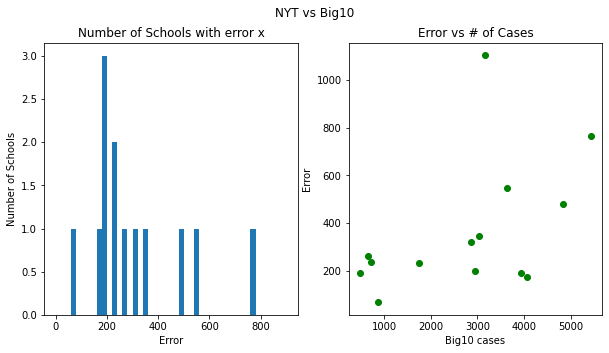

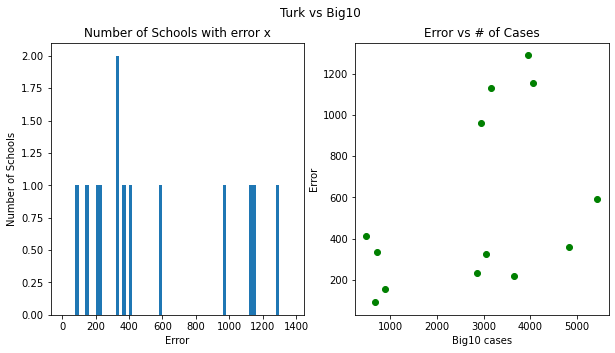

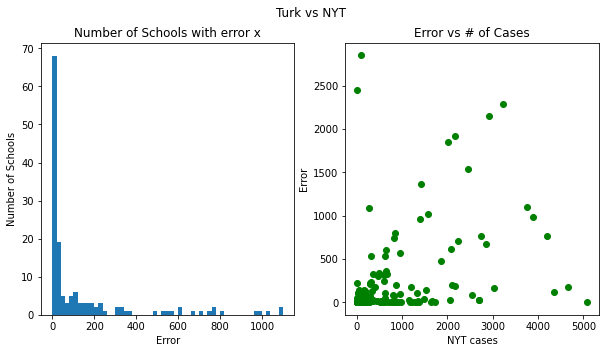

In [42]:
# Comparing with NYT's most recent update on 11/20/2020

# first compute the root mean square error and a list of errors

def rmsq(df_1, df_2, names):
    error = 0
    error_list = [] #list with values (abs(NYT Cases - Turk Cases), NYT Cases)
    count = 0
    for name1 in list(names.keys()):
        if(names[name1] != ""):
            case2 = df_2.loc[names[name1]]
            case2 = case2.Cases[-1]
            case1 = df_1.loc[name1].Cases[-1]
            
            if(not (math.isnan(case1) or math.isnan(case2))):
                error_list.append((abs(case1 - case2), case2))
                error += (case2 - case1)**2
                count += 1
    root_msq = math.sqrt(error/count) # Root mean squared error
    return root_msq, error_list


turk_nyt = name_dict
turk_big = {n[2]:n[0] for n in name_translator}
nyt_big = {n[1]:n[0] for n in name_translator}

pairings = [(nyt_df, big10_df),(turk_df, big10_df),(turk_df,nyt_df)]
translate = [nyt_big, turk_big, turk_nyt]
titles = [['NYT vs Big10','Big10'], ['Turk vs Big10','Big10'], ['Turk vs NYT','NYT']]

          
for i in range(len(pairings)):
    ms, listy = rmsq(pairings[i][0], pairings[i][1], translate[i])
        
    # I want to see how many schools are in each "error range"
    err,case = zip(*listy)

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle(titles[i][0])
    bins = range(0, int(2*ms),20)
    ax1.hist(err, bins)
    ax1.set_title("Number of Schools with error x")
    ax1.set(xlabel='Error', ylabel='Number of Schools')

    # Also is there a correlation between error and number of cases?
    # I'm thinking for schools with bigger case numbers there should be greater error
    ax2.plot(case,err,'go')
    ax2.set_title("Error vs # of Cases")
    ax2.set(xlabel=titles[i][1] + " cases", ylabel='Error')
    print("Root mean square error", titles[i][0] + ":", ms)


The graphs on the left show how the two data frames differ on the most current day available (11/19 for turk, 11/20 for NYT, somewhere between 11/15-11/21 for Big10). For example in Turk vs NYT, for almost 70 schools, the absolute value of (NYT reorted cases - turk reported cases) falls within the range of 0 to 20. Root mean sqaured error for each pair of datasets is also displayed at the top. 

What's slightly concerning is that on average, NYT appears to be more similar to Big10 than the Turk data is. There are 2 turk responses that are almost exactly equal to what we see in Big 10, but quite a few of them are more than 800 off. However, alot of turk data points are very similar to NYT cases. So maybe the turk data just looks bad compared with the big10 schools? Perhaps their dashboards are just tough to follow?

But, for more context, the graphs on the right compare error to case numbers (either Big10's or NYT's because I dont trust the turk case numbers yet). I thought it would make sense if schools with lower case numbers have lower errors. And, especially for Turk vs NYT this seems to be true. Im wondering if maybe the turk data just seems similar to NYT because of the low case number schools?  

### Lastly, I changed how I filter the values to see if that might make a difference:

Root mean square error NYT vs Big10: 453.5720922379847
Root mean square error Turk vs Big10: 685.6583585251365
Root mean square error Turk vs NYT: 517.8801257775052


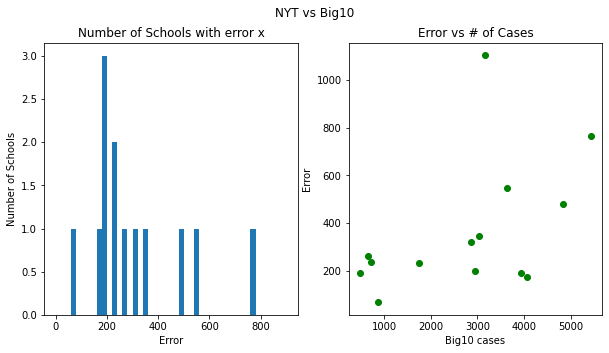

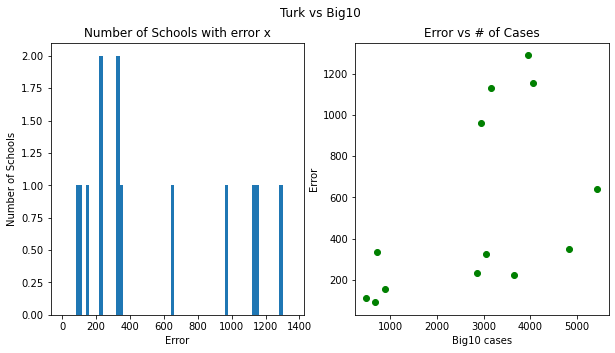

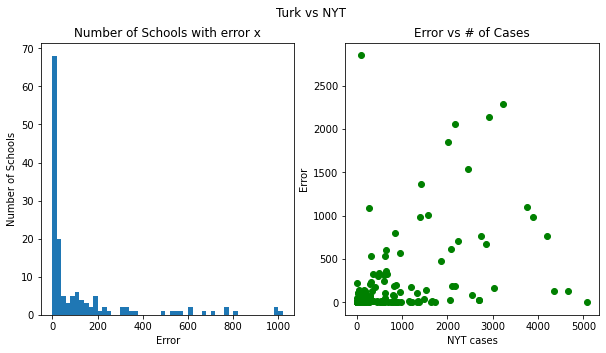

In [43]:
# We had the problem where two wrong answers that were exactly the same
# took priority over three right answers all slightly off from each other

# I changed this so that for every school I look at each response, count how many other answers are within +-5% of that response,
# and then take the agreed upon value to be the mean of the most common set of agreements

new_turk_df = pd.read_csv('../MTurk_Data/turk11_19_2020_filt.csv')
new_turk_df['Date'] = pd.to_datetime('2020-11-19',format='%Y-%m-%d')
Cases = new_turk_df['CumulativeCases'].copy()
Cases[new_turk_df['CumulativeCases'] == 'No agreed upon value'] = np.nan
new_turk_df['CumulativeCases'] = Cases.astype('float')
new_turk_df.index = pd.MultiIndex.from_frame(new_turk_df[['SchoolName', 'Date']])
new_turk_df.drop(['SchoolName', 'Unnamed: 0', 'Date'], axis = 1, inplace = True)
new_turk_df = new_turk_df.rename({'CumulativeCases':'Cases'}, axis = 'columns')


turk_nyt = name_dict
turk_big = {n[2]:n[0] for n in name_translator}
nyt_big = {n[1]:n[0] for n in name_translator}

pairings = [(nyt_df, big10_df),(new_turk_df, big10_df),(new_turk_df,nyt_df)]
translate = [nyt_big, turk_big, turk_nyt]
titles = [['NYT vs Big10','Big10'], ['Turk vs Big10','Big10'], ['Turk vs NYT','NYT']]

          
for i in range(len(pairings)):
    ms, listy = rmsq(pairings[i][0], pairings[i][1], translate[i])
        
    # I want to see how many schools are in each "error range"
    err,case = zip(*listy)

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle(titles[i][0])
    bins = range(0, int(2*ms),20)
    ax1.hist(err, bins)
    ax1.set_title("Number of Schools with error x")
    ax1.set(xlabel='Error', ylabel='Number of Schools')

    # Also is there a correlation between error and number of cases?
    # I'm thinking for schools with bigger case numbers there should be greater error
    ax2.plot(case,err,'go')
    ax2.set_title("Error vs # of Cases")
    ax2.set(xlabel=titles[i][1] + " cases", ylabel='Error')
    print("Root mean square error", titles[i][0] + ":", ms)



Before we had the problem where two wrong answers that were exactly the same took priority over three right answers all slightly off from each other. 

I changed this so that for every school I look at each response, count how many other answers are within +- 5% of that response, and then take the agreed upon value to be the mean of the most common set of agreements.

This improved mean square error between both Big10 vs Turk and NYT vs Turk so I think it's safe to say that this is probably the better way to filter out bad responses. However, it doesn't change what I found from before.  